# 프로젝트
- 00 약품 처방 건수 예측하기
- 파일명 : drugs.csv

# 주요 라이브러리

In [1]:
# 필요한 라이브러리 임포트
from sklearn.metrics import mean_squared_error, mean_absolute_error  # 모델 평가 지표
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # ACF, PACF 시각화
from statsmodels.tsa.seasonal import seasonal_decompose, STL  # 계절성 분해
from statsmodels.stats.diagnostic import acorr_ljungbox  # 잔차 검정
from statsmodels.tsa.statespace.sarimax import SARIMAX  # SARIMA 모델
from statsmodels.tsa.arima_process import ArmaProcess  # ARMA 프로세스
from statsmodels.graphics.gofplots import qqplot  # Q-Q plot
from statsmodels.tsa.stattools import adfuller  # 정상성 검정
from tqdm.auto import tqdm  # 진행률 표시
from itertools import product  # 파라미터 조합 생성
from typing import Union  # 타입 힌팅

# 기본 데이터 분석 및 시각화 라이브러리
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

# Jupyter notebook에서 그래프 인라인 표시
%matplotlib inline

C:\Users\Admin\Desktop\LGSW_statistics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('./data/drugs.csv')
df.head(10)

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
5,1991-12-01,4.306371
6,1992-01-01,5.088335
7,1992-02-01,2.814520
8,1992-03-01,2.985811
9,1992-04-01,3.204780


In [3]:
df.tail(10)

,ds,y
194,2007-09-01,22.930357
195,2007-10-01,23.263340
196,2007-11-01,25.250030
197,2007-12-01,25.806090
198,2008-01-01,29.665356
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510
203,2008-06-01,19.431740


In [4]:
df.shape

(204, 2)

## Visualization 

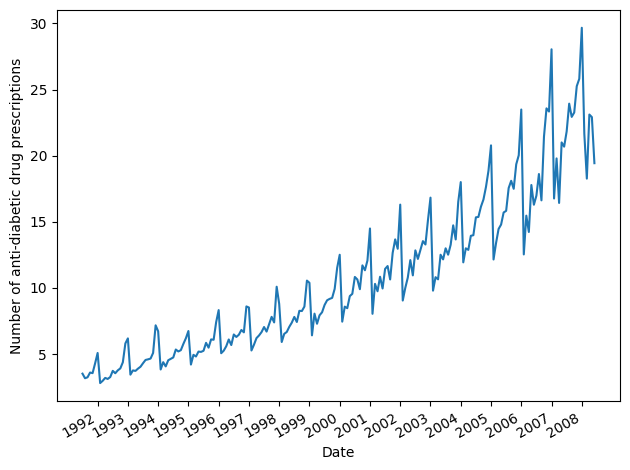

In [5]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 데이터 탐색
- 계절성 : 계절성 패턴을 보여주고, 일정한 주기로 반복되는 변동이 뚜렷함
- 잔차
    + 추세와 계절성을 제거한 후 남은 불규칙한 변동(잔차).
    + 대부분의 값이 0 근처에 분포하며, 특별한 패턴은 보이지 않습니다.

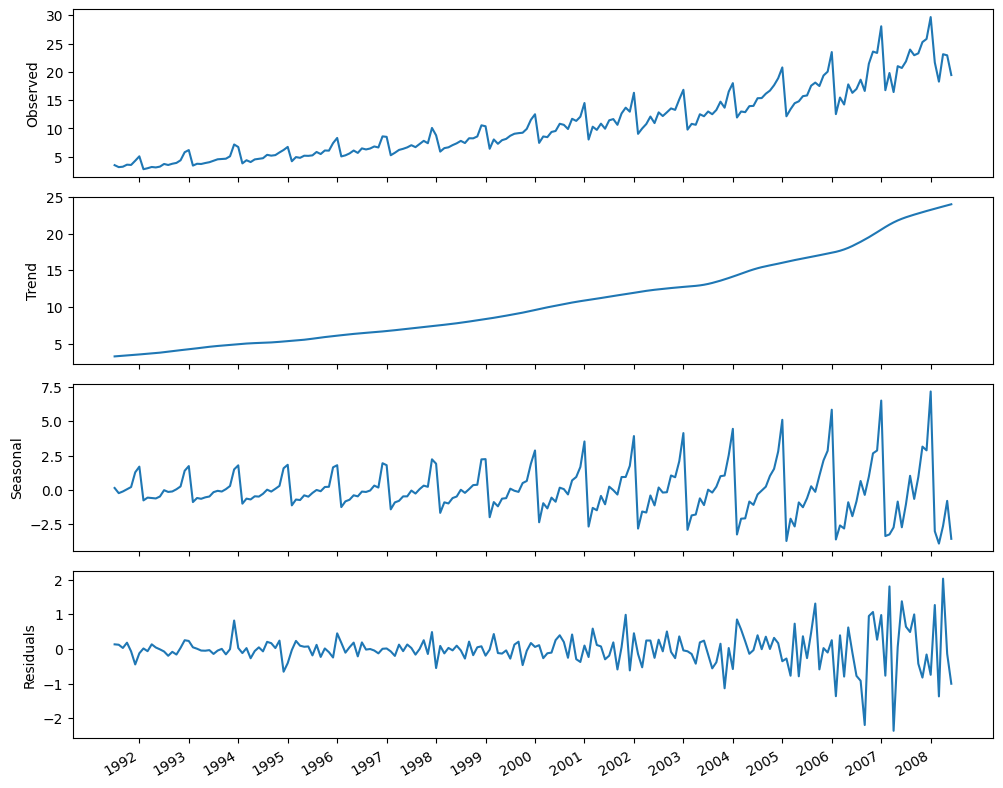

In [6]:
decomposition = STL(df.y, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## Modeling 

### 정상성 확인
- 귀무가설 : 정상성이 아니다. 
- 대립가설 : 정상성이다. 

In [7]:
ad_fuller_result = adfuller(df.y)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 3.145185689306735
p-value: 1.0


In [8]:
y_diff = np.diff(df.y, n=1)

ad_fuller_result = adfuller(y_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.495172147449726
p-value: 0.11665341686469105


In [9]:
y_diff_seasonal_diff = np.diff(y_diff, n=12)

ad_fuller_result = adfuller(y_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -19.848440098002758
p-value: 0.0


- 1차 차분과 계절성 차분을 적용했으므로, $d=1$과 $D=1$임. 
- 마지막으로, 월별 데이터이므로 $m=12$임

### Train/test split 

In [10]:
train = df.y[:168]
test = df.y[168:]

print(len(test))

36


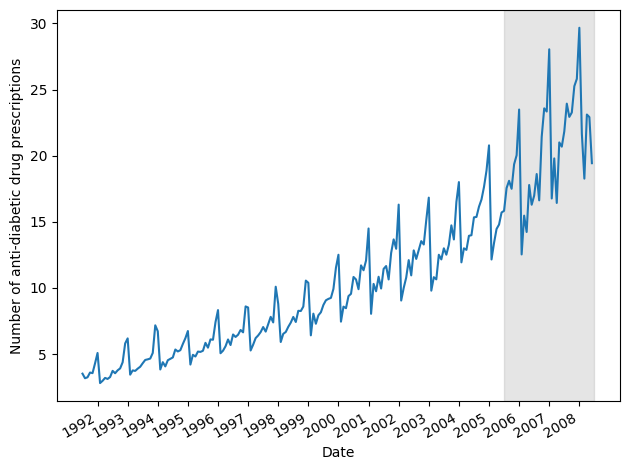

In [8]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

### SARIMA(p,1,q)(P,1,Q)<sub>12<sub> 

In [11]:
from typing import Union
from tqdm.auto import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [12]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 12

In [13]:
SARIMA_result_df = optimize_SARIMAX(train, None, order_list, d, D, s)
SARIMA_result_df

100%|████████████████████████████████████████| 625/625 [24:15<00:00,  2.33s/it]


,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 3)",270.951095
1,"(2, 4, 1, 3)",271.218028
2,"(3, 3, 1, 3)",271.304795
3,"(4, 1, 1, 3)",272.145293
4,"(0, 4, 1, 3)",272.152380
...,...,...
619,"(0, 0, 0, 4)",351.680917
620,"(0, 0, 2, 4)",353.276190
621,"(0, 0, 0, 1)",354.751719
622,"(0, 0, 1, 0)",357.173706


In [12]:
SARIMA_model = SARIMAX(train, order=(3,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  168
Model:             SARIMAX(3, 1, 3)x(1, 1, 3, 12)   Log Likelihood                -124.652
Date:                            Wed, 21 May 2025   AIC                            271.305
Time:                                    12:38:45   BIC                            304.782
Sample:                                         0   HQIC                           284.903
                                            - 168                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6759      0.198     -3.406      0.001      -1.065      -0.287
ar.L2         -0.7821      0.241   

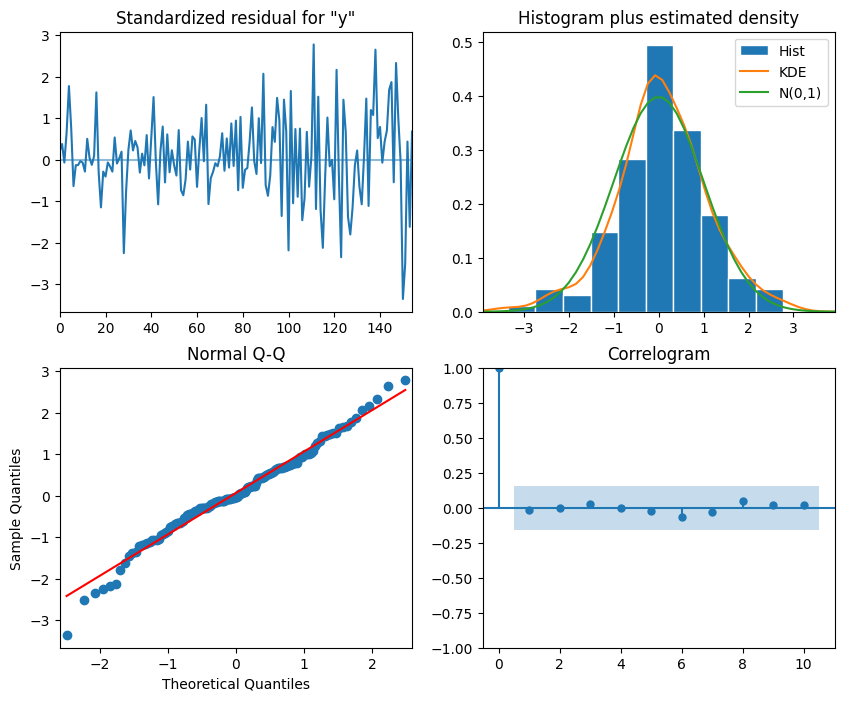

In [13]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

plt.show()

In [21]:
residuals = SARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.641051,0.423331
2,0.844864,0.655451
3,1.233753,0.744921
4,1.423991,0.840015
5,1.744731,0.883217
6,1.780981,0.938700
7,6.354611,0.499006
8,6.793271,0.559093
9,6.816558,0.656212
10,6.931159,0.731928


## Forecasting 

In [22]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(3,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

In [23]:
pred_df = df[168:]
pred_df

,ds,y
168,2005-07-01,15.829550
169,2005-08-01,17.554701
170,2005-09-01,18.100864
171,2005-10-01,17.496668
172,2005-11-01,19.347265
173,2005-12-01,20.031291
174,2006-01-01,23.486694
175,2006-02-01,12.536987
176,2006-03-01,15.467018
177,2006-04-01,14.233539


In [24]:
TRAIN_LEN = 168
HORIZON = 36
WINDOW = 12

pred_df['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')

pred_df

,ds,y,last_season
168,2005-07-01,15.829550,15.339097
169,2005-08-01,17.554701,15.370764
170,2005-09-01,18.100864,16.142005
171,2005-10-01,17.496668,16.685754
172,2005-11-01,19.347265,17.636728
173,2005-12-01,20.031291,18.869325
174,2006-01-01,23.486694,20.778723
175,2006-02-01,12.536987,12.154552
176,2006-03-01,15.467018,13.402392
177,2006-04-01,14.233539,14.459239


In [25]:
pred_df['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

pred_df

,ds,y,last_season,SARIMA
168,2005-07-01,15.829550,15.339097,16.693447
169,2005-08-01,17.554701,15.370764,16.500173
170,2005-09-01,18.100864,16.142005,17.236452
171,2005-10-01,17.496668,16.685754,18.094866
172,2005-11-01,19.347265,17.636728,18.421233
173,2005-12-01,20.031291,18.869325,19.963497
174,2006-01-01,23.486694,20.778723,22.130328
175,2006-02-01,12.536987,12.154552,13.635012
176,2006-03-01,15.467018,13.402392,15.210652
177,2006-04-01,14.233539,14.459239,15.688360


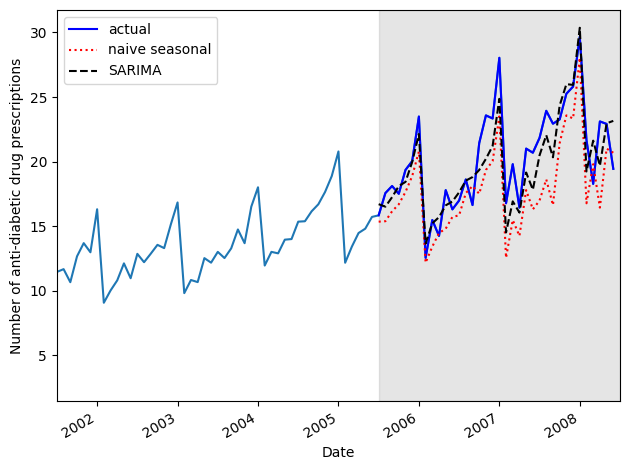

In [27]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.plot(pred_df.y, 'b-', label='actual')
ax.plot(pred_df.last_season, 'r:', label='naive seasonal')
ax.plot(pred_df.SARIMA, 'k--', label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
plt.xlim(120, 204)

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## Evaluate 

In [28]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
mape_naive_seasonal = mape(pred_df.y, pred_df.last_season)
mape_SARIMA = mape(pred_df.y, pred_df.SARIMA)

print(mape_naive_seasonal, mape_SARIMA)

12.686561923100614 7.669810556232911


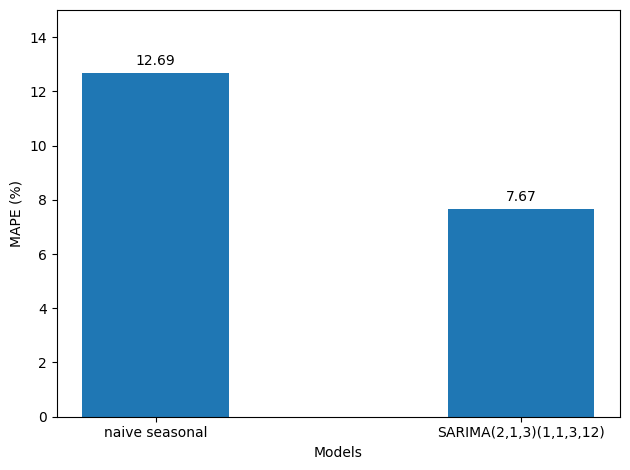

In [32]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'SARIMA(2,1,3)(1,1,3,12)']
y = [mape_naive_seasonal, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.3, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.show()